In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import jn,jnp_zeros

In [107]:
#define a pulse during [0,T], sample rate = fs, hight of time domain = h.
# def pulse(T, fs, h = 1.0):
#     length = int(T*fs)
#     pulse_signal = h*np.ones(length)
#     return pulse_signal
class Signal:
    def __init__(self, _T, _fs, _signal_TD = None):
        self.T = _T
        self.fs = _fs
        self.length = int(self.T*self.fs)+1
        self.time_series = 1/self.fs*np.arange(self.length)
        self.signal_TD = _signal_TD

    def pulse(self, h = 1.0):
        self.signal_TD = h*np.ones(int(self.T*self.fs)+1)

    def add_zero(self, *args):
        num_args = len(args)
        if num_args == 0:
            _N = 2**math.ceil(math.log(self.length,2))
        else:
            _N = args[0]
        zero_length = _N - self.length
        self.length = _N
        self.signal_TD = np.append(self.signal_TD,np.zeros(zero_length))
        self.time_series = 1/self.fs*np.arange(self.length)



class EWM:
    def __init__(self, _delta_frequency):
    # delta_frequency = fs/N = 1/T
        self.delta_frequency = _delta_frequency
    
    def set_eta(self, m):
        self.eta = math.log(10)*m*self.delta_frequency
        
    def falling_exp_window(self, vector, time_series):
        exponential_time_series = np.exp(-self.eta*time_series)
        return np.multiply(vector,exponential_time_series)
    
    def rising_exp_window(self, vector, time_series):
        exponential_time_series = np.exp(self.eta*time_series)
        return np.multiply(vector,exponential_time_series)
    
#     def FFT(self, signal_TD):
#         signal_FD = np.fft.fft(signal_TD)
#         return signal_FD
    
#     def IFFT(self, signal_FD):
#         signal_TD = np.fft.ifft(signal_FD)
#         return signal_TD
    
    
class SimplifiedModel:
    def __init__(self, _radius, _c, _rho, _strength, _num_terms, _num_modes = 0,  _distance_off_center = 0):
        self.radius = _radius
        # c denote speed of sound in fluid
        self.c = _c
        self.rho = _rho
        self.strength = _strength
        self.num_terms =  _num_terms
        self.num_modes = _num_modes
        self.distance_off_center = _distance_off_center
    def transfer(self, r, theta, z, w):
        if self.distance_off_center == 0:
            # in this case , result independent of theta
            #z denote zeros of the functions J_n'(x)
            n = 0
            k = np.array(jnp_zeros(n,self.num_terms)/self.radius)
            k_0 = np.array(w/self.c).T
#             sqrt_vec = k*k
            sqrt_vec = np.sqrt(k_0*k_0-k*k)
            truncated_series =  np.exp(-1j*z*sqrt_vec)/sqrt_vec*jn(n, k*r)/(jn(n, k*self.radius)*jn(n, k*self.radius))
            transfer_function = np.sum(truncated_series)
            return transfer_function
             
        else:
            print(f"The code is not available for off-center ponint souce")
            
    def displacement_response(self, r, theta, z, eta = 0):
        N = len(self.strength)//2 + 1
        w = 2*np.pi/N*np.arange(len(self.strength)) - 1j*eta
        displacement = np.zeros(N, dtype=complex)
        for i in range(N):
            displacement[i] = 1j/(2*np.pi*self.radius*self.radius)*self.transfer(r, theta, z, w[i])*self.strength[i]
        conj_displacement = np.conjugate(displacement[1:-1])[::-1]
        displacement = np.append(displacement, conj_displacement)
        return displacement
    def pressure_response(self, r, theta, z, eta = 0):
        N = len(self.strength)//2 + 1
        w = 2*np.pi/N*np.arange(len(self.strength)) - 1j*eta
        pressure = np.zeros(N, dtype=complex)
        for i in range(N):
            pressure[i] = self.rho/(self.c*self.radius*self.radius)*w[i]*self.transfer(r, theta, z, w[i])*self.strength[i]
        conj_pressure = np.conjugate(pressure[1:-1])[::-1]
        pressure = np.append(pressure, conj_pressure)
        return pressure

def Solver(T, fs, h, m, R, c ,rho, _num_terms, r, z):
    pulse_T = Signal(T, fs)
    pulse_T.pulse(h)
    num_fft_mode  = 2**math.ceil(math.log(pulse_T.length,2))
    pulse_T.add_zero(num_fft_mode)
    #    EWM
    _delta_frequency =  1/T
    ewm = EWM(_delta_frequency)
    ewm.set_eta(m)
    # forcing function after FEW
    strength_few = ewm.falling_exp_window(pulse_T.signal_TD, pulse_T.time_series)
    #    FFT
    _strength = np.fft.fft(strength_few)
    # print("strength_FD", _strength)
    #  calculate response
    simplemodel = SimplifiedModel(R, c, rho, _strength, _num_terms)
    theta = 0
    displacement_response = simplemodel.displacement_response(r, theta, z, ewm.eta)
    pressure_response = simplemodel.pressure_response(r, theta, z, ewm.eta)
    # print("pressure_response", pressure_response)

    #  IFFT
    displacement = np.fft.ifft(displacement_response)
    pressure = np.fft.ifft(pressure_response)
    # print('pressure_TD',pressure)
    #  REW
    displacement = ewm.rising_exp_window(displacement, pulse_T.time_series)
    pressure = ewm.rising_exp_window(pressure, pulse_T.time_series)
    # displacement, pressure = Solver(T, fs, h, m, R, c ,rho, _num_terms, r, z)
    t = pulse_T.time_series
    return displacement, pressure, displacement_response, pressure_response, t

d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'pressure_FD')

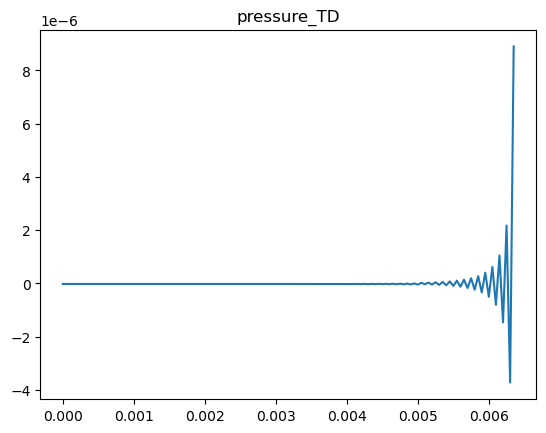

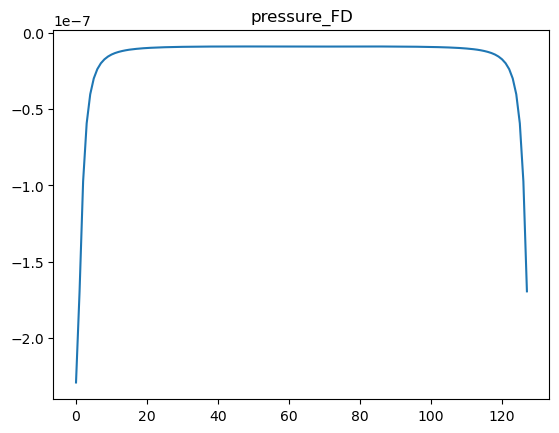

In [108]:
# table of parameters
#pulse of 5ms
T = 0.005
#sample rate of pulse
fs = 20000
#height of pulse
h = 10
#calculate eta
m = 3.5
#radius of pipe, unit m 
R = 1
#speed of sound in fliud ,unit km/s
c = 1.5
#terms of Bessel function
_num_terms = 10
#density of fliud
rho = 1.0
#axis distance from source, unit:km
z = 0.02
#radius distance from source
r = 0.5

displacement, pressure, displacement_response, pressure_response, t = Solver(T, fs, h, m, R, c ,rho, _num_terms, r, z)
plt.figure(1)
plt.plot(t,pressure)
plt.title('pressure_TD')
plt.figure(2)
plt.plot(pressure_response)
plt.title('pressure_FD')
# plt.figure(2)
# plt.plot(t,displacement)
# plt.title('dislpacement')

In [ ]:
# pulse_T = Signal(T, fs)
# pulse_T.pulse(h)
# num_fft_mode  = 2**math.ceil(math.log(pulse_T.length,2))
# pulse_T.add_zero(num_fft_mode)
# #    EWM
# _delta_frequency =  1/T
# ewm = EWM(_delta_frequency)
# ewm.set_eta(m)
# # forcing function after FEW
# strength_few = ewm.falling_exp_window(pulse_T.signal_TD, pulse_T.time_series)
# #    FFT
# _strength = np.fft.fft(strength_few)
# # print("strength_FD", _strength)
# #  calculate response
# simplemodel = SimplifiedModel(R, c, rho, _strength, _num_terms)
# theta = 0
# displacement_response = simplemodel.displacement_response(r, theta, z, ewm.eta)
# pressure_response = simplemodel.pressure_response(r, theta, z, ewm.eta)
# # print("pressure_response", pressure_response)

# #  IFFT
# displacement = np.fft.ifft(displacement_response)
# pressure = np.fft.ifft(pressure_response)
# # print('pressure_TD',pressure)
# #  REW
# displacement = ewm.rising_exp_window(displacement, pulse_T.time_series)
# pressure = ewm.rising_exp_window(pressure, pulse_T.time_series)
# # displacement, pressure = Solver(T, fs, h, m, R, c ,rho, _num_terms, r, z)
# t = pulse_T.time_series

In [44]:
#
T = 0.004
fs = 1000
pulse_T = Signal(T, fs)
pulse_T.pulse(h)
# 定义一个共轭对称的复数向量
signal = pulse_T.signal_TD

# FFT 变换
freq_domain_signal = np.fft.fft(signal)

# 截取频域信号，假设只保留前一半频谱（正频率部分）
# half_length = len(freq_domain_signal) // 2
truncated_freq_domain_signal = freq_domain_signal
# [:half_length]

# 共轭处理
conjugate_freq_domain_signal = np.conjugate(truncated_freq_domain_signal)

# IFFT 变换
time_domain_result = np.fft.ifft(conjugate_freq_domain_signal)
print(time_domain_result)

[10.-0.j 10.+0.j 10.+0.j 10.+0.j 10.+0.j]


In [76]:
def my_function(*args):
    num_args = len(args)

    if num_args == 0:
        case_0()
    elif num_args == 1:
        case_1(args[0])
    else:
        print("Too many arguments!")

def case_0():
    print("Executing case 0")

def case_1(arg):
    print(f"Executing case 1 with argument: {arg}")

# 测试
my_function()       # 执行 case_0
my_function(42)     # 执行 case_1
my_function(1, 2)   # 输出 "Too many arguments!"


Executing case 0
Executing case 1 with argument: 42
Too many arguments!
